Loading data into DataFrame...
✅ Full data loaded successfully. Total samples: 245538

--- Running EDA on a random subset of 1000 samples ---

--- Performing Data Integrity Check ---
Number of missing labels: 0


Checking image files: 100%|██████████| 1000/1000 [00:00<00:00, 1480.02it/s]


✅ All image files exist.

--- Analyzing Labels ---


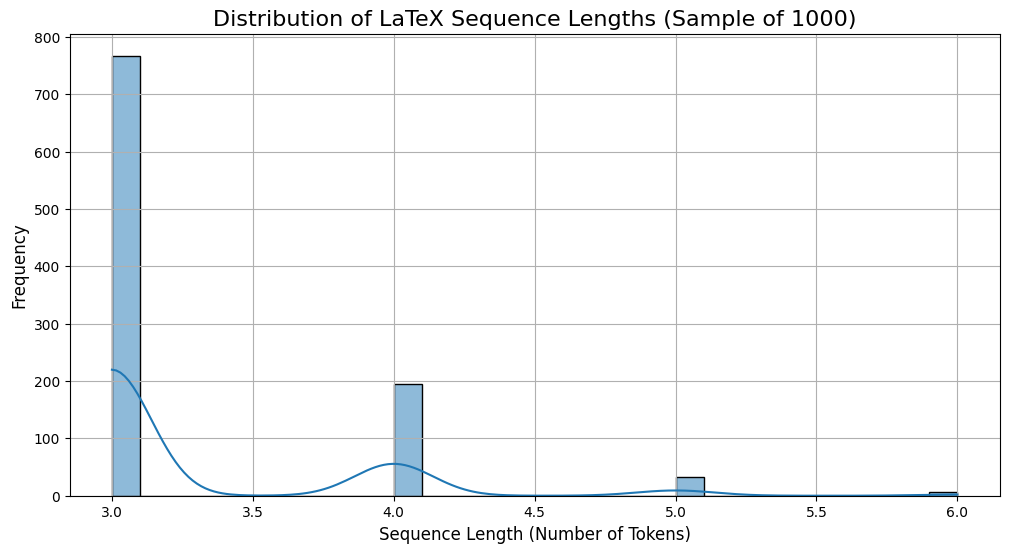

Label Length Statistics (Sample of 1000):
count    1000.000000
mean        3.279000
std         0.554497
min         3.000000
25%         3.000000
50%         3.000000
75%         3.000000
max         6.000000
Name: label_length, dtype: float64

--- Analyzing Vocabulary and Token Frequency (Sample of 1000) ---
Total unique tokens (Vocabulary Size): 1166


C:\Users\HP\AppData\Local\Temp\ipykernel_43824\730127511.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='frequency', y='token', data=common_df, palette='viridis')


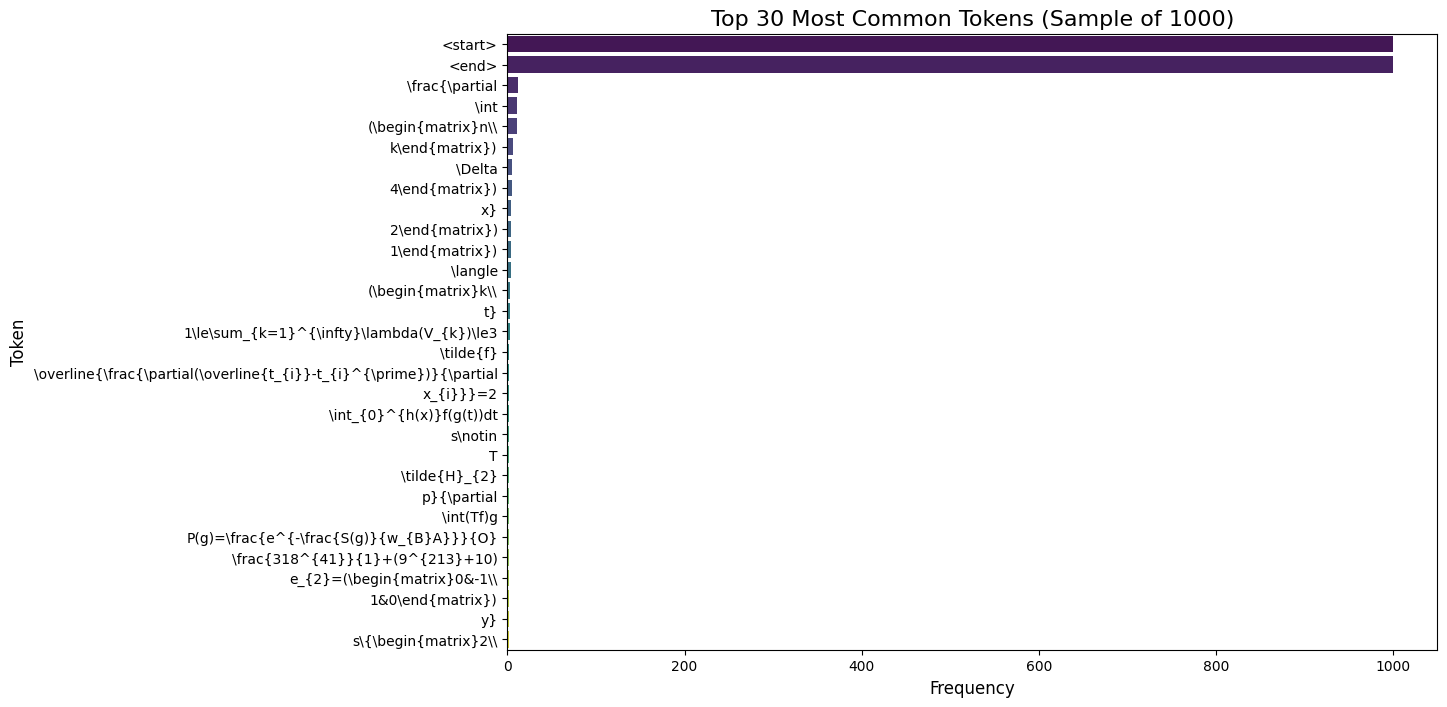


Top 10 Most Common Tokens: [('<start>', 1000), ('<end>', 1000), ('\\frac{\\partial', 12), ('\\int', 11), ('(\\begin{matrix}n\\\\', 11), ('k\\end{matrix})', 6), ('\\Delta', 5), ('4\\end{matrix})', 5), ('x}', 4), ('2\\end{matrix})', 4)]
Top 10 Least Common Tokens: [('C_{p}=(\\frac{\\partial', 1), ('H}{\\partial', 1), ('T})_{P}', 1), ('[\\begin{matrix}c&-s\\\\', 1), ('s&c\\end{matrix}]', 1), ('{(\\nu^{\\phi})}^{\\alpha}', 1), ('Q=\\int_{V}j^{0}dV', 1), ('\\frac{e^{\\cdot\\frac{9}{x^{5}}}}{x}', 1), ('\\overline{V}[p]', 1), ('f(x)=\\frac{1}{2}x^{T}Ax', 1)]

--- Displaying Sample Images with Labels ---


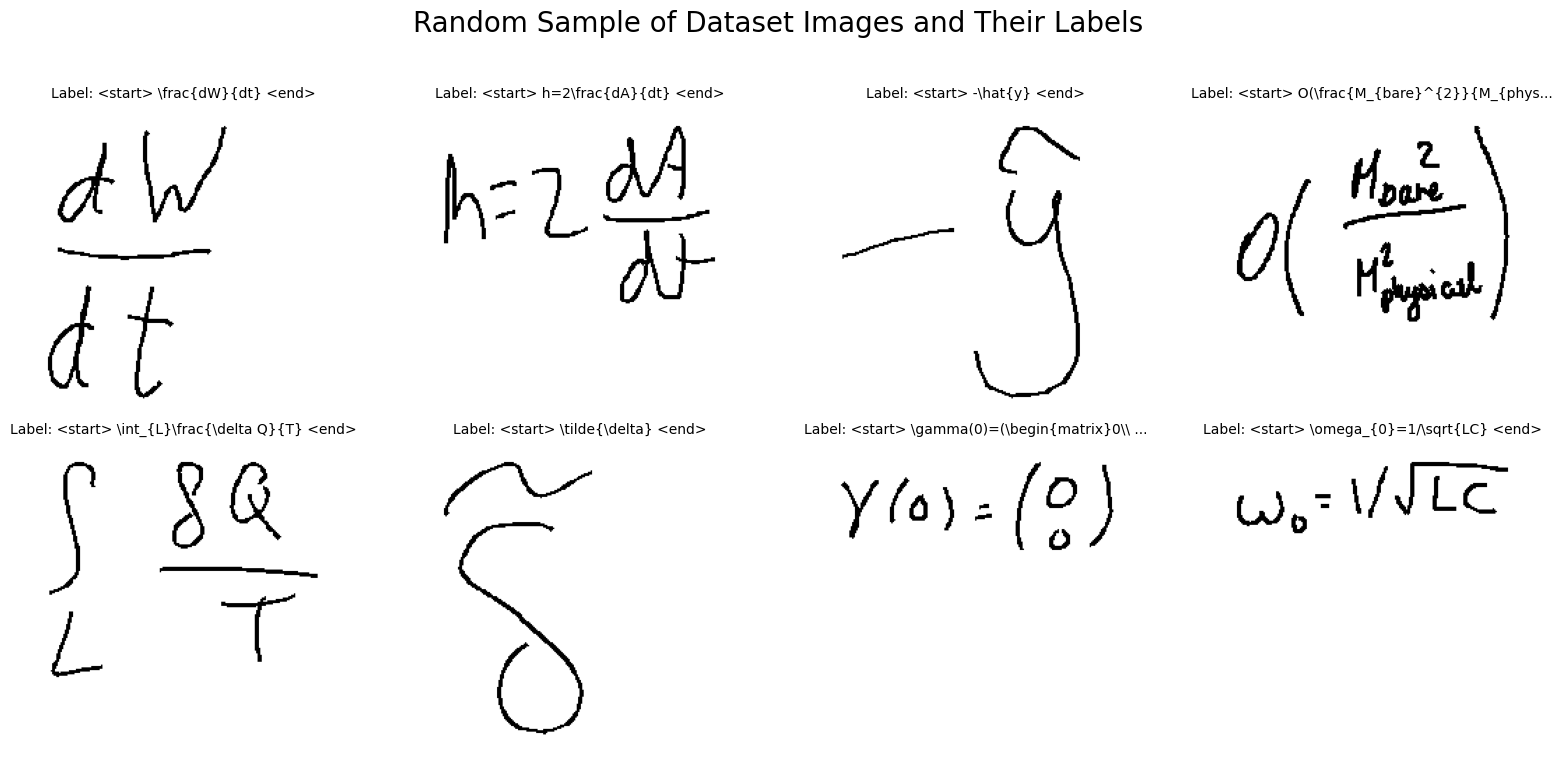

In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from PIL import Image
from tqdm import tqdm
import numpy as np

# --- 1. SETUP: Define paths and load data ---
# IMPORTANT: Update these paths to match your dataset location
TRAIN_IMG_DIR = r'D:\OCR_MATH\formula_images\train\images'
TRAIN_LABELS_FILE = r'D:\OCR_MATH\formula_images\train\labels.txt'
VALID_IMG_DIR = r'D:\OCR_MATH\formula_images\valid\images'
VALID_LABELS_FILE = r'D:\OCR_MATH\formula_images\valid\labels.txt'

def load_dataset_to_dataframe(img_dir, labels_file):
    """Loads image paths and captions into a Pandas DataFrame."""
    if not os.path.exists(labels_file):
        raise FileNotFoundError(f"Labels file not found at {labels_file}.")
    
    data = []
    with open(labels_file, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                filename, caption = line.strip().split(',', 1)
                data.append([os.path.join(img_dir, filename), caption])
            except ValueError:
                continue
    return pd.DataFrame(data, columns=['image_path', 'label'])

# Load both training and validation data into a single DataFrame for overall analysis
print("Loading data into DataFrame...")
train_df = load_dataset_to_dataframe(TRAIN_IMG_DIR, TRAIN_LABELS_FILE)
valid_df = load_dataset_to_dataframe(VALID_IMG_DIR, VALID_LABELS_FILE)
df_full = pd.concat([train_df, valid_df], ignore_index=True)
print(f"✅ Full data loaded successfully. Total samples: {len(df_full)}")

# MODIFIED: Take a random sample of 1000 to speed up EDA
df = df_full.sample(n=1000, random_state=42).reset_index(drop=True)
print(f"\n--- Running EDA on a random subset of {len(df)} samples ---\n")


# --- 2. DATA INTEGRITY CHECK ---
print("--- Performing Data Integrity Check ---")
# Check for missing labels
missing_labels = df['label'].isnull().sum()
print(f"Number of missing labels: {missing_labels}")

# Check for non-existent image files
missing_files = []
for path in tqdm(df['image_path'], desc="Checking image files"):
    if not os.path.exists(path):
        missing_files.append(path)

if missing_files:
    print(f"⚠️ Found {len(missing_files)} image files that do not exist.")
else:
    print("✅ All image files exist.")


# --- 3. LABEL ANALYSIS ---
print("\n--- Analyzing Labels ---")
df['label_length'] = df['label'].apply(lambda x: len(x.split()))

# a) Plotting the distribution of sequence lengths
plt.figure(figsize=(12, 6))
sns.histplot(df['label_length'], bins=30, kde=True)
plt.title('Distribution of LaTeX Sequence Lengths (Sample of 1000)', fontsize=16)
plt.xlabel('Sequence Length (Number of Tokens)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)
plt.show()

print("Label Length Statistics (Sample of 1000):")
print(df['label_length'].describe())

# b) Analyzing vocabulary and token frequency (class imbalance)
print("\n--- Analyzing Vocabulary and Token Frequency (Sample of 1000) ---")
all_tokens = [token for label in df['label'] for token in label.split()]
token_counts = Counter(all_tokens)

print(f"Total unique tokens (Vocabulary Size): {len(token_counts)}")

# Plot the top 30 most common tokens
common_tokens = token_counts.most_common(30)
common_df = pd.DataFrame(common_tokens, columns=['token', 'frequency'])

plt.figure(figsize=(12, 8))
sns.barplot(x='frequency', y='token', data=common_df, palette='viridis')
plt.title('Top 30 Most Common Tokens (Sample of 1000)', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Token', fontsize=12)
plt.show()

print("\nTop 10 Most Common Tokens:", token_counts.most_common(10))
print("Top 10 Least Common Tokens:", token_counts.most_common()[-10:])


# --- 4. IMAGE ANALYSIS ---
print("\n--- Displaying Sample Images with Labels ---")
sample_df = df.sample(n=8, random_state=42)

plt.figure(figsize=(16, 8))
for i, (index, row) in enumerate(sample_df.iterrows()):
    plt.subplot(2, 4, i + 1)
    try:
        image = Image.open(row['image_path']).convert('L')
        plt.imshow(image, cmap='gray')
        title_text = row['label']
        if len(title_text) > 40:
            title_text = title_text[:37] + '...'
        plt.title(f"Label: {title_text}", fontsize=10)
        plt.axis('off')
    except FileNotFoundError:
        plt.title("Image not found", fontsize=10)
        plt.axis('off')

plt.suptitle('Random Sample of Dataset Images and Their Labels', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [4]:
import tensorflow as tf
import numpy as np
import os
import argparse
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet_preprocess_input

# --- 1. CONFIGURATION ---
EMBEDDING_DIM = 256
UNITS = 512
IMG_SIZE = (224, 224)
VOCAB_FILE = r'D:\OCR_MATH\vocab.txt' # Assumes the file is in the same directory as the script

# --- 2. LOAD VOCABULARY AND PREPARE TOKENIZER ---
def load_vocab(vocab_file):
    with open(vocab_file, 'r', encoding='utf-8') as f:
        vocab = [line.strip() for line in f]
    return vocab

print("Loading vocabulary...")
try:
    full_vocabulary = load_vocab(VOCAB_FILE)
except FileNotFoundError:
    print(f"Error: Vocabulary file '{VOCAB_FILE}' not found. Please place it in the same folder as this script.")
    exit()

VOCAB_SIZE = len(full_vocabulary)
MAX_LENGTH = 14 # Set this from your training output
print(f"Vocabulary Size: {VOCAB_SIZE}")

clean_vocabulary = full_vocabulary[2:]
index_to_word = tf.keras.layers.StringLookup(
    vocabulary=clean_vocabulary, invert=True, oov_token='[UNK]', mask_token=''
)
start_token_index = full_vocabulary.index('<start>')

# --- 3. HELPER FUNCTIONS AND MODEL DEFINITIONS ---
def load_and_preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = resnet_preprocess_input(img)
    return img

class CNN_Encoder(tf.keras.Model):
    def __init__(self, trainable=False):
        super(CNN_Encoder, self).__init__()
        self.image_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(*IMG_SIZE, 3))
        self.image_model.trainable = trainable
        feature_output_layer = self.image_model.get_layer('conv5_block3_out').output
        self.reshape = tf.keras.layers.Reshape((-1, feature_output_layer.shape[-1]))
        self.feature_extractor = tf.keras.Model(inputs=self.image_model.input, outputs=self.reshape(feature_output_layer))
    def call(self, x, training=False):
        return self.feature_extractor(x, training=training)

class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1, self.W2, self.V = tf.keras.layers.Dense(units), tf.keras.layers.Dense(units), tf.keras.layers.Dense(1)
    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = tf.reduce_sum(attention_weights * features, axis=1)
        return context_vector, attention_weights

class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.LSTM(self.units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.dropout = tf.keras.layers.Dropout(0.5)
        self.fc2 = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.units)
    def call(self, x, features, hidden, training=False):
        context_vector, _ = self.attention(features, hidden[0])
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state_h, state_c = self.lstm(x, initial_state=hidden)
        x = self.fc1(output)
        x = tf.reshape(x, (-1, x.shape[2]))
        x = self.dropout(x, training=training)
        x = self.fc2(x)
        return x, [state_h, state_c], None
    def reset_state(self, batch_size):
        return [tf.zeros((batch_size, self.units)) for _ in range(2)]

# --- 4. PREDICTION FUNCTION ---
def evaluate(image_path, encoder_model, decoder_model):
    img_tensor = load_and_preprocess_image(image_path)
    features = encoder_model(tf.expand_dims(img_tensor, 0), training=False)
    hidden = decoder_model.reset_state(batch_size=1)
    dec_input = tf.expand_dims([start_token_index], 0)
    result = []
    for i in range(MAX_LENGTH):
        predictions, hidden, _ = decoder_model(dec_input, features, hidden, training=False)
        predicted_id = tf.argmax(predictions[0]).numpy()
        predicted_word = index_to_word(tf.constant([predicted_id])).numpy()[0].decode('utf-8')
        if predicted_word == '<end>': break
        if predicted_word not in ['<start>', '[UNK]', '']:
            result.append(predicted_word)
        dec_input = tf.expand_dims([predicted_id], 0)
    return " ".join(result)

# --- 5. MAIN EXECUTION BLOCK ---
if __name__ == "__main__":
    # CORRECTED: Hardcode the path to the image you want to test
    image_to_predict = 'D:\OCR_MATH\image\image.jpg' # Make sure this path is correct

    # CORRECTED: Check the existence of the correct variable
    if not os.path.exists(image_to_predict):
        print(f"Error: Image file not found at '{image_to_predict}'")
        exit()

    # Create model instances
    encoder = CNN_Encoder(trainable=False)
    decoder = RNN_Decoder(EMBEDDING_DIM, UNITS, VOCAB_SIZE)

    # Build the models by running a dummy forward pass
    print("Building models...")
    dummy_img = tf.random.normal((1, *IMG_SIZE, 3))
    dummy_features = encoder(dummy_img, training=False)
    dummy_hidden = decoder.reset_state(1)
    decoder(tf.random.uniform((1, 1), maxval=10, dtype=tf.int32), dummy_features, dummy_hidden, training=False)
    print("Models built.")

    # Restore from the latest checkpoint
    checkpoint_dir = r'D:\OCR_MATH\checkpoints' # Assumes folder is in the same directory
    checkpoint = tf.train.Checkpoint(encoder=encoder, decoder=decoder)
    latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
    
    if latest_checkpoint:
        checkpoint.restore(latest_checkpoint).expect_partial()
        print(f"✅ Model restored successfully from {latest_checkpoint}")
        
        # Now, run the prediction
        # CORRECTED: Use the correct variable
        prediction = evaluate(image_to_predict, encoder, decoder)
        print("-" * 30)
        # CORRECTED: Use the correct variable
        print(f"Image: {image_to_predict}")
        print(f"Prediction: {prediction}")
        print("-" * 30)
    else:
        print(f"⚠️ No checkpoint found in '{checkpoint_dir}'. Cannot make a prediction.")

Loading vocabulary...
Vocabulary Size: 64456
Building models...
Models built.
✅ Model restored successfully from D:\OCR_MATH\checkpoints\ckpt-5
------------------------------
Image: D:\OCR_MATH\image\image.jpg
Prediction: \frac{d}{dt}N_{2}
------------------------------


In [6]:
!pip install nltk tqdm

     ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
     - -------------------------------------- 0.0/1.5 MB 960.0 kB/s eta 0:00:02
     --- ------------------------------------ 0.1/1.5 MB 1.6 MB/s eta 0:00:01
     -------- ------------------------------- 0.3/1.5 MB 2.5 MB/s eta 0:00:01
     --------------- ------------------------ 0.6/1.5 MB 3.2 MB/s eta 0:00:01
     ---------------------- ----------------- 0.8/1.5 MB 3.8 MB/s eta 0:00:01
     ------------------------------- -------- 1.2/1.5 MB 4.4 MB/s eta 0:00:01
     ---------------------------------------  1.5/1.5 MB 4.8 MB/s eta 0:00:01
     ---------------------------------------- 1.5/1.5 MB 4.4 MB/s eta 0:00:00
  Using cached click-8.3.0-py3-none-any.whl (107 kB)
  Using cached regex-2025.9.18-cp310-cp310-win_amd64.whl (276 kB)



[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet_preprocess_input

# --- ALL DEFINITIONS NEEDED FOR SETUP ---

# Helper function to load the dataset
def load_dataset_from_files(img_dir, labels_file):
    image_paths, captions = [], []
    with open(labels_file, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                filename, caption = line.strip().split(',', 1)
                image_paths.append(os.path.join(img_dir, filename))
                captions.append(caption)
            except ValueError:
                continue
    return image_paths, captions

# Helper function to process images
def load_and_preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = resnet_preprocess_input(img)
    return img

# Model Class: CNN_Encoder
class CNN_Encoder(tf.keras.Model):
    def __init__(self, trainable=False):
        super(CNN_Encoder, self).__init__()
        self.image_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
        self.image_model.trainable = trainable
        feature_output_layer = self.image_model.get_layer('conv5_block3_out').output
        self.reshape = tf.keras.layers.Reshape((-1, feature_output_layer.shape[-1]))
        self.feature_extractor = tf.keras.Model(inputs=self.image_model.input, outputs=self.reshape(feature_output_layer))
    def call(self, x, training=False):
        return self.feature_extractor(x, training=training)

# Model Class: BahdanauAttention
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1, self.W2, self.V = tf.keras.layers.Dense(units), tf.keras.layers.Dense(units), tf.keras.layers.Dense(1)
    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = tf.reduce_sum(attention_weights * features, axis=1)
        return context_vector, attention_weights

# Model Class: RNN_Decoder
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.LSTM(self.units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.dropout = tf.keras.layers.Dropout(0.5)
        self.fc2 = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.units)
    def call(self, x, features, hidden, training=False):
        context_vector, _ = self.attention(features, hidden[0])
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state_h, state_c = self.lstm(x, initial_state=hidden)
        x = self.fc1(output)
        x = tf.reshape(x, (-1, x.shape[2]))
        x = self.dropout(x, training=training)
        x = self.fc2(x)
        return x, [state_h, state_c], None
    def reset_state(self, batch_size):
        return [tf.zeros((batch_size, self.units)) for _ in range(2)]

# Evaluation function
def evaluate(image_path, encoder_model, decoder_model):
    # This must be defined before the evaluation script can use it.
    # Note: index_to_word, max_length, start_token_index must be defined globally
    img_tensor = load_and_preprocess_image(image_path)
    features = encoder_model(tf.expand_dims(img_tensor, 0), training=False)
    hidden = decoder_model.reset_state(batch_size=1)
    dec_input = tf.expand_dims([start_token_index], 0)
    result = []
    for i in range(max_length):
        predictions, hidden, _ = decoder_model(dec_input, features, hidden, training=False)
        predicted_id = tf.argmax(predictions[0]).numpy()
        predicted_word = index_to_word(tf.constant([predicted_id])).numpy()[0].decode('utf-8')
        if predicted_word == '<end>': break
        if predicted_word not in ['<start>', '[UNK]', '']:
            result.append(predicted_word)
        dec_input = tf.expand_dims([predicted_id], 0)
    return " ".join(result)

# --- END OF DEFINITIONS ---


# --- SETUP LOGIC ---

# 1. Load the dataset paths
print("Loading validation dataset...")
VALID_IMG_DIR = r'D:\OCR_MATH\formula_images\valid\images'
VALID_LABELS_FILE = r'D:\OCR_MATH\formula_images\valid\labels.txt'
valid_image_paths, valid_captions = load_dataset_from_files(VALID_IMG_DIR, VALID_LABELS_FILE)
print(f"✅ Validation data loaded with {len(valid_image_paths)} samples.")

# 2. Load vocabulary and define tokenizers
# You will need to get the vocab.txt from your training session
VOCAB_FILE = 'vocab.txt' # Make sure this file is in your directory
try:
    full_vocabulary = [line.strip() for line in open(VOCAB_FILE, 'r', encoding='utf-8')]
except FileNotFoundError:
    print(f"ERROR: vocab.txt not found. Please save it from your training notebook and place it here.")
    # This will stop the script if vocab is missing
    raise

clean_vocabulary = full_vocabulary[2:]
index_to_word = tf.keras.layers.StringLookup(
    vocabulary=clean_vocabulary, invert=True, oov_token='[UNK]', mask_token=''
)
start_token_index = full_vocabulary.index('<start>')
max_length = 14 # Set from your training output

# 3. Load your trained model from the checkpoint
print("\nLoading trained model from checkpoint...")
EMBEDDING_DIM = 256
UNITS = 512
VOCAB_SIZE = len(full_vocabulary)

encoder = CNN_Encoder(trainable=False)
decoder = RNN_Decoder(EMBEDDING_DIM, UNITS, VOCAB_SIZE)

print("Building models...")
dummy_img = tf.random.normal((1, 224, 224, 3))
dummy_features = encoder(dummy_img, training=False)
dummy_hidden = decoder.reset_state(1)
decoder(tf.random.uniform((1, 1), maxval=10, dtype=tf.int32), dummy_features, dummy_hidden, training=False)
print("Models built.")

checkpoint_dir = r'D:\OCR_MATH\checkpoints'
checkpoint = tf.train.Checkpoint(encoder=encoder, decoder=decoder)
manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)

if manager.latest_checkpoint:
    checkpoint.restore(manager.latest_checkpoint).expect_partial()
    print(f"✅ Model restored successfully from {manager.latest_checkpoint}")
else:
    print("⚠️ Warning: No checkpoint found. Model has random weights.")

print("\nSetup complete. You can now run the evaluation cell.")

Loading validation dataset...
✅ Validation data loaded with 15674 samples.

Loading trained model from checkpoint...
Building models...
Models built.
✅ Model restored successfully from D:\OCR_MATH\checkpoints\ckpt-5

Setup complete. You can now run the evaluation cell.


In [4]:
import numpy as np
import nltk
from tqdm import tqdm

def levenshtein_distance(s1, s2):
    """Calculates the Levenshtein distance between two strings."""
    if len(s1) < len(s2): return levenshtein_distance(s2, s1)
    if len(s2) == 0: return len(s1)
    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    return previous_row[-1]

# --- Main Evaluation Loop (Limited to 1000 samples) ---
print("\nRunning evaluation on a subset of 1000 validation samples...")

# MODIFIED: Define the number of samples to evaluate
num_samples_to_evaluate = 1000

# MODIFIED: Slice the data lists to the desired number of samples
paths_to_evaluate = valid_image_paths[:num_samples_to_evaluate]
captions_to_evaluate = valid_captions[:num_samples_to_evaluate]

true_labels, predictions = [], []

# MODIFIED: Loop over the smaller, sliced lists
for img_path, true_caption in tqdm(zip(paths_to_evaluate, captions_to_evaluate), total=len(paths_to_evaluate)):
    predicted_caption = evaluate(img_path, encoder, decoder)
    clean_true_caption = true_caption.replace('<start>', '').replace('<end>', '').strip()
    true_labels.append(clean_true_caption)
    predictions.append(predicted_caption)

# --- Calculate Metrics ---
# This part of the code remains the same
exact_matches = sum(1 for true, pred in zip(true_labels, predictions) if true == pred)
exact_match_rate = (exact_matches / len(true_labels)) * 100

total_distance = sum(levenshtein_distance(true, pred) for true, pred in zip(true_labels, predictions))
total_length = sum(len(true) for true in true_labels)
cer = (total_distance / total_length) * 100

references = [[label.split()] for label in true_labels]
hypotheses = [pred.split() for pred in predictions]
bleu_score = nltk.translate.bleu_score.corpus_bleu(references, hypotheses)

# --- Print Final Results ---
print("\n" + "="*40)
print("      Model Evaluation Metrics (on 1000 samples)")
print("="*40)
print(f"Total Validation Samples: {len(true_labels)}")
print(f"✅ Exact Match Rate: {exact_match_rate:.2f}%")
print(f"📉 Character Error Rate (CER): {cer:.2f}% (Lower is better)")
print(f"📈 Corpus BLEU Score: {bleu_score:.4f} (Higher is better)")
print("="*40)


Running evaluation on a subset of 1000 validation samples...


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [09:19<00:00,  1.79it/s]



      Model Evaluation Metrics (on 1000 samples)
Total Validation Samples: 1000
✅ Exact Match Rate: 9.50%
📉 Character Error Rate (CER): 80.17% (Lower is better)
📈 Corpus BLEU Score: 0.0142 (Higher is better)


Running character-level evaluation on 1000 samples...


100%|██████████| 1000/1000 [8:42:00<00:00, 31.32s/it]      



✅ Character-Level Accuracy: 21.04%


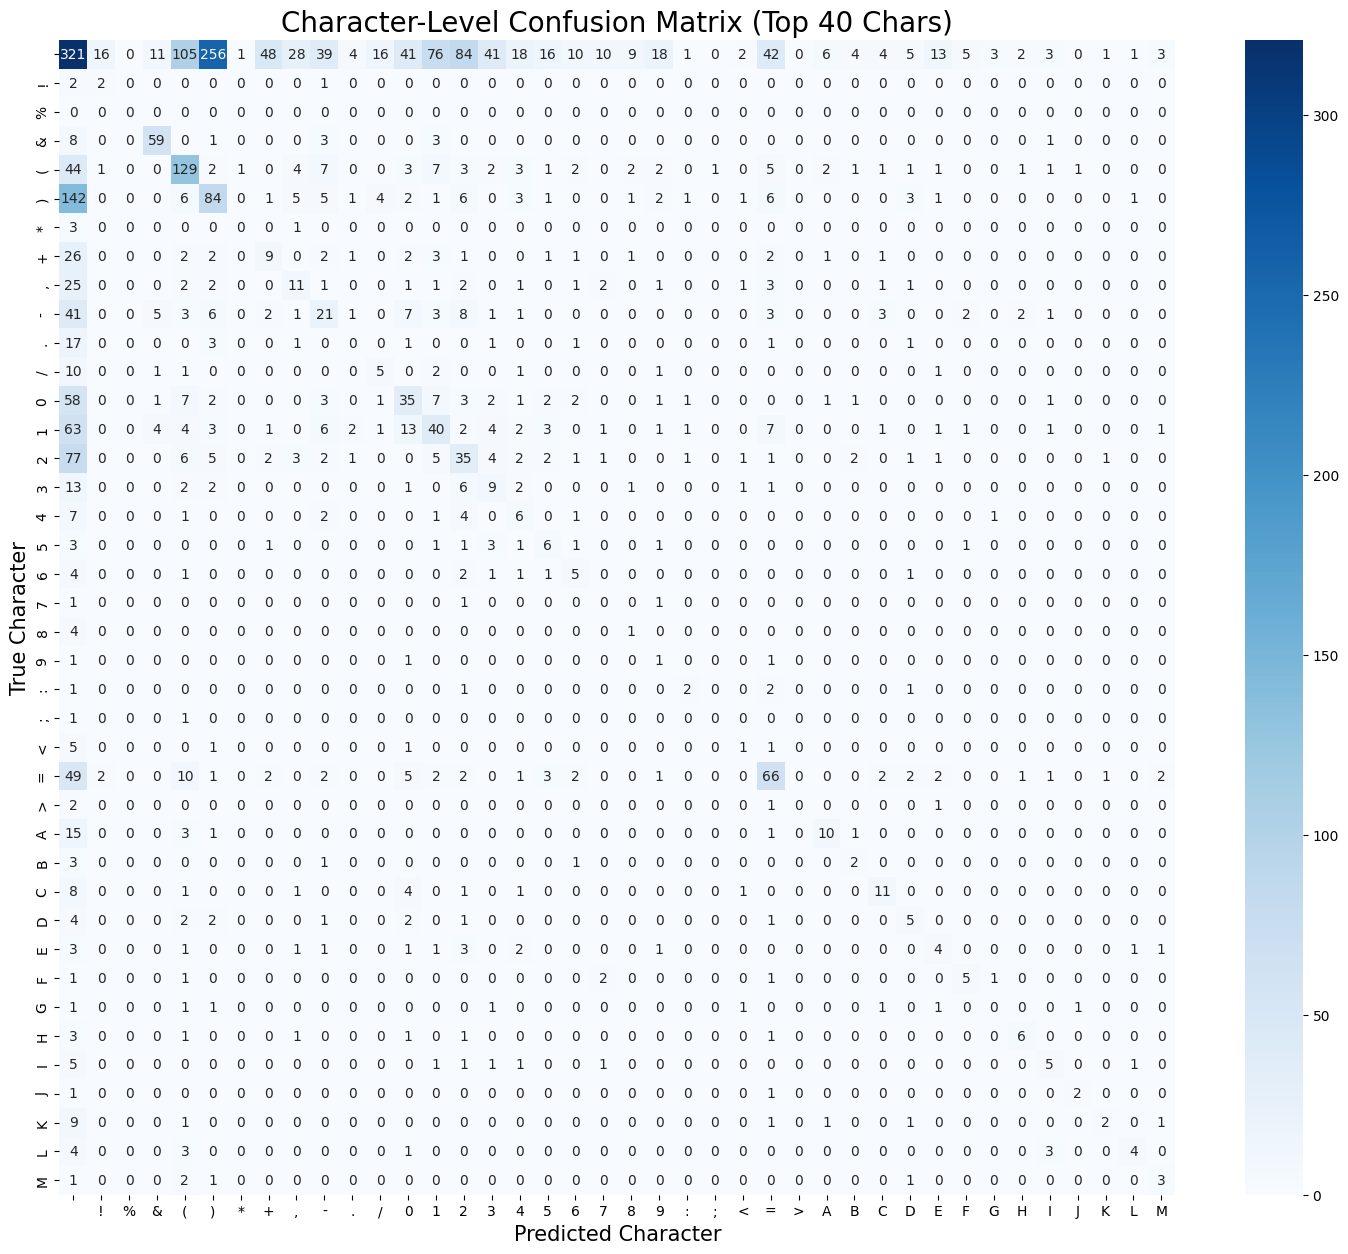

In [10]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from tqdm import tqdm
import pandas as pd

# --- Main Evaluation Loop for Character-Level Analysis ---
print("Running character-level evaluation on 1000 samples...")

num_samples = 1000
paths_to_evaluate = valid_image_paths[:num_samples]
captions_to_evaluate = valid_captions[:num_samples]

all_true_chars = []
all_pred_chars = []

for img_path, true_caption in tqdm(zip(paths_to_evaluate, captions_to_evaluate), total=num_samples):
    predicted_caption = evaluate(img_path, encoder, decoder)
    clean_true_caption = true_caption.replace('<start>', '').replace('<end>', '').strip()
    
    # Pad the shorter string to make lengths equal for character comparison
    max_len = max(len(clean_true_caption), len(predicted_caption))
    clean_true_caption = clean_true_caption.ljust(max_len)
    predicted_caption = predicted_caption.ljust(max_len)
    
    all_true_chars.extend(list(clean_true_caption))
    all_pred_chars.extend(list(predicted_caption))

# --- Calculate and Print Character-Level Accuracy ---
char_accuracy = accuracy_score(all_true_chars, all_pred_chars)
print("\n" + "="*40)
print(f"✅ Character-Level Accuracy: {char_accuracy * 100:.2f}%")
print("="*40)

# --- Generate and Plot the Confusion Matrix ---

# Get the unique characters to use as labels for the matrix
labels = sorted(list(set(all_true_chars + all_pred_chars)))
# Limit to a reasonable number of labels for visibility, e.g., the first 30
if len(labels) > 40:
    labels = labels[:40]

# Create the confusion matrix
cm = confusion_matrix(all_true_chars, all_pred_chars, labels=labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(18, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Character-Level Confusion Matrix (Top 40 Chars)', fontsize=20)
plt.xlabel('Predicted Character', fontsize=15)
plt.ylabel('True Character', fontsize=15)
plt.show()